# Artificial Neural Network with Genetic Algorithm for Weather Forecasting

This notebook implements a Genetic Algorithm (GA) to optimize hyperparameters for a neural network that predicts temperature based on weather features.

## 1. Import Libraries

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Prepare Data

In [14]:
#Load the dataset
df = pd.read_csv("ECTA 2023 Dataset.csv")

#Select features and target
features = ['Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure', 'Wind_Chill', 'Dewpoint Temp']
target = 'Temperature'

#Display first five rows
df.head()

,Date,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature
0,2010-01-01,00:00:00,2010,1,1,53,1,4,1,0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3
1,2010-01-01,01:00:00,2010,1,1,53,1,4,1,1,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3
2,2010-01-01,02:00:00,2010,1,1,53,1,4,1,2,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6
3,2010-01-01,03:00:00,2010,1,1,53,1,4,1,3,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8
4,2010-01-01,04:00:00,2010,1,1,53,1,4,1,4,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7


In [15]:
#Drop rows with missing values
df = df.dropna()

#Extract features and target
X = df[features].values
y = df[target].values

#Split dataset into training and testing sets (80% and 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize input features
#Create a object called scalar using StandardScalar() from sklearn
#Scaling is done so that all input features are in a similar range, x_scaled = (x - mean)/sd
#This makes the data centred at 0
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (77145, 6)
Testing data shape: (19287, 6)


## 3. Define Neural Network Model

In [16]:
def build_ann(lr, neurons1, neurons2):
    model = keras.Sequential([
        #Sequential model (layers are added one after the other)
        keras.layers.Input(shape=(X_train.shape[1],)),#This defines the shape of each input sample and the number of features coming in
        keras.layers.Dense(neurons1, activation='relu'),
        keras.layers.Dense(neurons2, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)#Optimizes the wieghts and biases of the network using Adam's algorithm
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

## 4. Define Hyperparameter Bounds and Evaluation Function

In [17]:
#Define hyperparameter bounds
HP_BOUNDS = {'lr': (0.0001, 0.1),'neurons1': (16, 128),'neurons2': (16, 128),'batch_size': (8, 64)}

#Counter to track evaluations
eval_counter = 0

def evaluate_individual(individual):
    global eval_counter
    eval_counter += 1
    
    #Extract hyperparameters from the individual
    lr, neurons1, neurons2, batch_size = individual
    
    #Convert to integers where needed
    neurons1 = int(neurons1)
    neurons2 = int(neurons2)
    batch_size = int(batch_size)
    
    print(f"\n[{eval_counter}] Evaluating: LR={lr:.5f}, Neurons1={neurons1}, Neurons2={neurons2}, Batch Size={batch_size}")
    
    #Build and train the model
    model = build_ann(lr, neurons1, neurons2)
    history = model.fit(
        X_train, y_train,
        epochs=10,  #Using a fixed number of epochs for evaluation
        batch_size=batch_size,
        verbose=0
    )
    
    #Evaluate the model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"[{eval_counter}] MAE: {mae:.4f}")
    
    #For GA, we return the negative MAE as fitness (higher is better)
    return -mae

## 5. Custom Genetic Algorithm Implementation

Based on the algorithm described in the research paper

In [ ]:
def create_random_individual():
    individual = [
        random.uniform(HP_BOUNDS['lr'][0], HP_BOUNDS['lr'][1]),
        random.randint(HP_BOUNDS['neurons1'][0], HP_BOUNDS['neurons1'][1]),
        random.randint(HP_BOUNDS['neurons2'][0], HP_BOUNDS['neurons2'][1]),
        random.randint(HP_BOUNDS['batch_size'][0], HP_BOUNDS['batch_size'][1])
    ]
    return individual

def create_initial_population(pop_size):
    return [create_random_individual() for _ in range(pop_size)]

def roulette_wheel_selection(population, fitness_values):
    #Make all fitness values positive by adding the minimum value if needed
    min_fitness = min(fitness_values)
    if min_fitness < 0:
        adjusted_fitness = [f - min_fitness + 0.1 for f in fitness_values] #Add a small constant to avoid zeros
    else:
        adjusted_fitness = [f + 0.1 for f in fitness_values] #Add a small constant to avoid zeros
    
    #Calculate selection probabilities
    total_fitness = sum(adjusted_fitness)
    selection_probs = [f/total_fitness for f in adjusted_fitness]

    
    #Select based on fitness probability
    r = random.random()
    cumulative_prob = 0
    for i, prob in enumerate(selection_probs):
        cumulative_prob += prob
        if r <= cumulative_prob:
            return population[i]
    
    #Fallback
    return population[-1]

def uniform_crossover(parent1, parent2):
    child = []
    for i in range(len(parent1)):
        #For each gene, randomly select from either parent
        if random.random() < 0.5:
            child.append(parent1[i])
        else:
            child.append(parent2[i])
    return child

def mutate(individual):
    mutated = individual.copy()
    
    #For each gene, decide whether to mutate it
    for i in range(len(mutated)):
        if random.random() < 0.2:  #20% chance of mutation for each gene
            if i == 0:  #Learning rate (float)
                mutated[i] = random.uniform(HP_BOUNDS['lr'][0], HP_BOUNDS['lr'][1])
            elif i == 1:  #Neurons1 (int)
                mutated[i] = random.randint(HP_BOUNDS['neurons1'][0], HP_BOUNDS['neurons1'][1])
            elif i == 2:  #Neurons2 (int)
                mutated[i] = random.randint(HP_BOUNDS['neurons2'][0], HP_BOUNDS['neurons2'][1])
            elif i == 3:  #Batch size (int)
                mutated[i] = random.randint(HP_BOUNDS['batch_size'][0], HP_BOUNDS['batch_size'][1])
    
    return mutated

def run_genetic_algorithm(pop_size=5, generations=3, crossover_prob=0.7, mutation_prob=0.2):
    global eval_counter
    eval_counter = 0
    
    #Create initial population
    population = create_initial_population(pop_size)
    
    #Evaluate initial population
    fitness_values = [evaluate_individual(ind) for ind in population]
    
    #Keep track of the best individual
    best_idx = fitness_values.index(max(fitness_values))
    best_individual = population[best_idx]
    best_fitness = fitness_values[best_idx]
    
    print(f"\nInitial best fitness: {best_fitness}")
    
    #Evolution loop
    for generation in range(generations):
        print(f"\n=== Generation {generation+1}/{generations} ===")
        
        #Create new population
        new_population = []
        
        #Elitism: keep the best individual
        new_population.append(best_individual)
        
        #Create the rest of the new population
        while len(new_population) < pop_size:
            #Selection
            parent1 = roulette_wheel_selection(population, fitness_values)
            parent2 = roulette_wheel_selection(population, fitness_values)
            
            #Crossover
            if random.random() < crossover_prob:
                child = uniform_crossover(parent1, parent2)
            else:
                child = parent1.copy()  #No crossover, just copy parent1
            
            #Mutation
            if random.random() < mutation_prob:
                child = mutate(child)
            
            new_population.append(child)
        
        #Replace old population
        population = new_population
        
        #Evaluate new population
        fitness_values = [evaluate_individual(ind) for ind in population]
        
        #Update best individual
        current_best_idx = fitness_values.index(max(fitness_values))
        current_best_individual = population[current_best_idx]
        current_best_fitness = fitness_values[current_best_idx]
        
        if current_best_fitness > best_fitness:
            best_individual = current_best_individual
            best_fitness = current_best_fitness
        
        print(f"Best fitness in generation {generation+1}: {current_best_fitness}")
        print(f"Overall best fitness so far: {best_fitness}")
    
    return best_individual, best_fitness

## 6. Run the Genetic Algorithm

In [19]:
#Run the genetic algorithm
best_hyperparams, best_fitness = run_genetic_algorithm(
    pop_size=5,
    generations=3,
    crossover_prob=0.7,
    mutation_prob=0.2
)

#Convert the fitness back to MAE
best_mae = -best_fitness

print("\n" + "="*50)
print("Best Hyperparameters:")
print(f"Learning Rate: {best_hyperparams[0]:.5f}")
print(f"Neurons Layer 1: {int(best_hyperparams[1])}")
print(f"Neurons Layer 2: {int(best_hyperparams[2])}")
print(f"Batch Size: {int(best_hyperparams[3])}")
print(f"Best MAE: {best_mae:.4f}")
print("="*50)


[1] Evaluating: LR=0.06398, Neurons1=19, Neurons2=110, Batch Size=25
[1] MAE: 0.3247

[2] Evaluating: LR=0.02456, Neurons1=33, Neurons2=110, Batch Size=14
[2] MAE: 0.1209

[3] Evaluating: LR=0.06770, Neurons1=85, Neurons2=27, Batch Size=45
[3] MAE: 0.1306

[4] Evaluating: LR=0.04225, Neurons1=19, Neurons2=27, Batch Size=21
[4] MAE: 0.1691

[5] Evaluating: LR=0.02334, Neurons1=93, Neurons2=19, Batch Size=43
[5] MAE: 0.1280

Initial best fitness: -0.12086530774831772

=== Generation 1/3 ===

[6] Evaluating: LR=0.02456, Neurons1=33, Neurons2=110, Batch Size=14
[6] MAE: 0.1408

[7] Evaluating: LR=0.02456, Neurons1=85, Neurons2=110, Batch Size=14
[7] MAE: 0.1049

[8] Evaluating: LR=0.06770, Neurons1=85, Neurons2=110, Batch Size=45
[8] MAE: 0.1458

[9] Evaluating: LR=0.04225, Neurons1=19, Neurons2=19, Batch Size=43
[9] MAE: 0.0939

[10] Evaluating: LR=0.02334, Neurons1=93, Neurons2=19, Batch Size=43
[10] MAE: 0.1147
Best fitness in generation 1: -0.09393564611673355
Overall best fitness so 

## 7. Train Final Model with Best Hyperparameters

In [20]:
#Extract the best hyperparameters
best_lr = best_hyperparams[0]
best_neurons1 = int(best_hyperparams[1])
best_neurons2 = int(best_hyperparams[2])
best_batch_size = int(best_hyperparams[3])

#Build and train the final model
final_model = build_ann(best_lr, best_neurons1, best_neurons2)

print("Training final model with best hyperparameters...")
history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

Training final model with best hyperparameters...
Epoch 1/50
1795/1795 [==============================] - 16s 9ms/step - loss: 0.7256 - mae: 0.3329 - val_loss: 0.0404 - val_mae: 0.1499
Epoch 2/50
1795/1795 [==============================] - 16s 9ms/step - loss: 0.0593 - mae: 0.1749 - val_loss: 0.1620 - val_mae: 0.3357
Epoch 3/50
1795/1795 [==============================] - 15s 8ms/step - loss: 0.0790 - mae: 0.1968 - val_loss: 0.1195 - val_mae: 0.2863
Epoch 4/50
1795/1795 [==============================] - 18s 10ms/step - loss: 0.0633 - mae: 0.1671 - val_loss: 0.0839 - val_mae: 0.2240
Epoch 5/50
1795/1795 [==============================] - 14s 8ms/step - loss: 0.0544 - mae: 0.1594 - val_loss: 0.0574 - val_mae: 0.1661
Epoch 6/50
1795/1795 [==============================] - 15s 8ms/step - loss: 0.0448 - mae: 0.1510 - val_loss: 0.0327 - val_mae: 0.1403
Epoch 7/50
1795/1795 [==============================] - 14s 8ms/step - loss: 0.0397 - mae: 0.1422 - val_loss: 0.0316 - val_mae: 0.1431
Epoc

## 8. Evaluate Final Model

In [21]:
loss, mae = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Model Test MAE: {mae:.4f}")

603/603 [==============================] - 4s 7ms/step - loss: 0.0130 - mae: 0.0870
Final Model Test MAE: 0.0870


## 9. Visualize Training Results

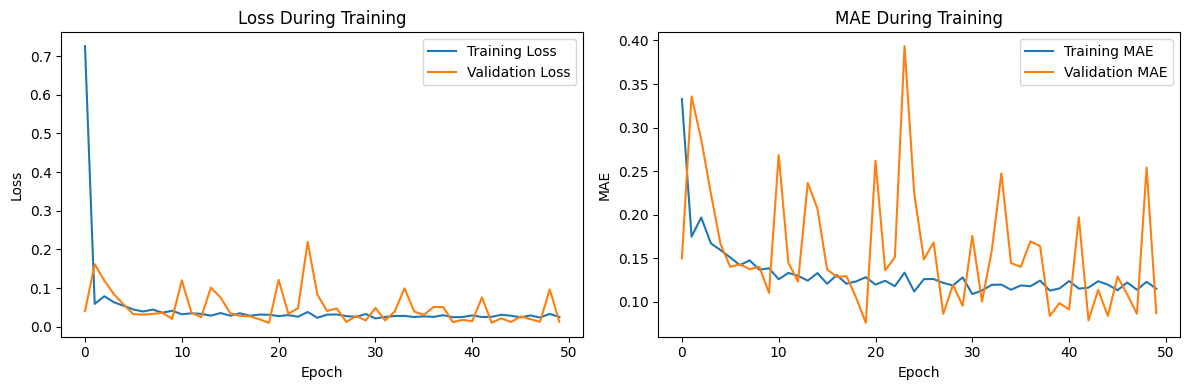

In [22]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## 10. Make Predictions

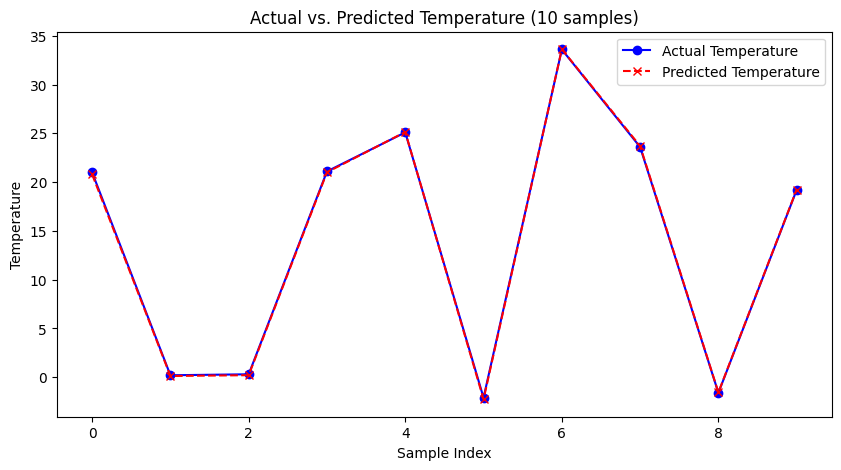

In [23]:
# Make predictions on test data
y_pred = final_model.predict(X_test, verbose=0)

# Plot actual vs predicted temperature (first 10 samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test[:10], label='Actual Temperature', color='blue', marker='o')
plt.plot(y_pred[:10], label='Predicted Temperature', color='red', linestyle='dashed', marker='x')
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperature (10 samples)")
plt.show()

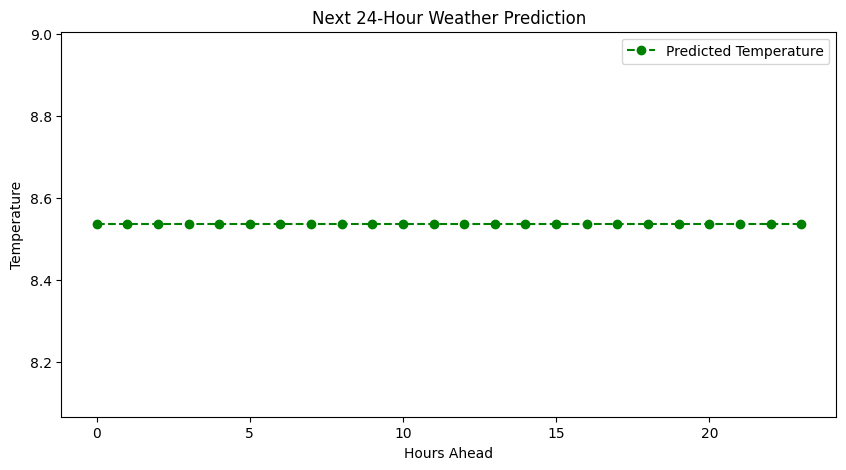

In [24]:
#Predict next 24 hours (using mean of test features for simplicity)
future_X = np.tile(np.mean(X_test, axis=0), (24, 1))
future_y_pred = final_model.predict(future_X, verbose=0)

#Plot next 24 hours forecast
plt.figure(figsize=(10, 5))
plt.plot(future_y_pred, marker='o', linestyle='dashed', color='green', label='Predicted Temperature')
plt.xlabel("Hours Ahead")
plt.ylabel("Temperature")
plt.title("Next 24-Hour Weather Prediction")
plt.legend()
plt.show()